In [17]:
#Biblioteket
import numpy as np
import matplotlib.pyplot as plt

In [18]:
#Enklar deklaratioer av konstanter
mu = 3        #Friktionskoffecient 2=<mu<=4, vi valde medelvärdet
g = 9.82      #(m/s^2) tyngdfaktor

Cd = 0.3      #luftmotståndskoeffecient ENHETSLÖS!
Af = 1.63     #(m^2) frontarea
p_air = 1.2   #(kg/m^3)   luftdensitet 

C_rr = 0.03   #rullmotståndskoffecient 

In [19]:
#Implementering av ekvationerna som vi har från In 2 del (TEKNISKA KRAV)       
def F_aero(Hast):  #(N) Luftmotstånds-kraft
    F_aero = 0.5 * Cd * Af * p_air * Hast**2
    return F_aero

def F_roll(grad, mass):   #(N) Rullmotståndets kraftkomposant
    return C_rr * mass * g * np.cos(grad)

def F_grad(grad, mass):     #(N) Den vertikala gradientens kraftkomposant 
    F_grad= mass * g * np.sin(grad)
    return F_grad


In [20]:
#Implementering av ekvationerna som vi har från In 2 del (FYSIKALISK MODELL)

#----------------------Enkla Deklarationer--------------------------------------
lamda = 10.03 * 2.325        #(Wb) Eller (Vs) Flödeskonstant
Ra = 0.039 * 2.325           #(Ohm) Resistans 
r_hjul = 0.46482             #(m) 36.6 (inches) / 2 *0.0254 = 0.46482 (m)
T_f = 15.905 * 2.325         #(Nm) Friktionsförluster i motor
n = 0.982                    #Verkningsgrad ENHETSLÖS!
i = 5                      #Utväxlingen ENHETSLÖS! (Vi valde planet Växel)

#-----------------------Ekvationer----------------------------------------------
def T_e(ia):            #(Nm) Motorvridmoment
    T_e= ia * lamda
    return T_e

def w_r(v_veh):             #(rad/s) varvtal för elmotorn
    w_r= (v_veh/r_hjul)/i     
    return w_r 



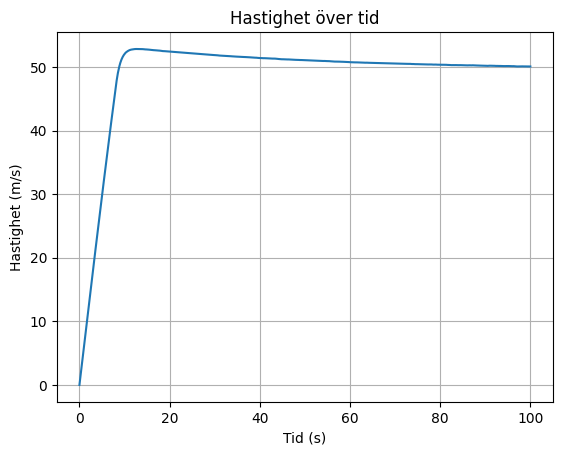

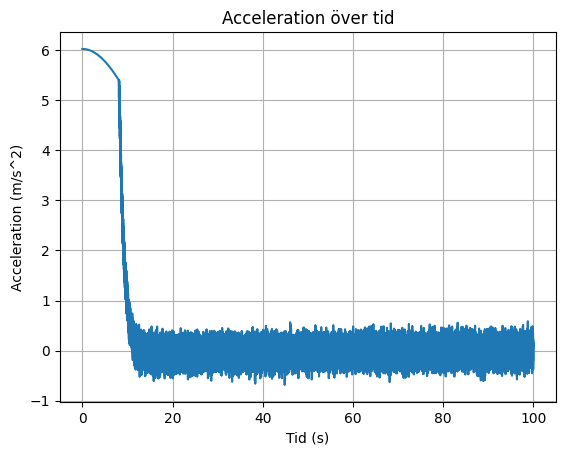

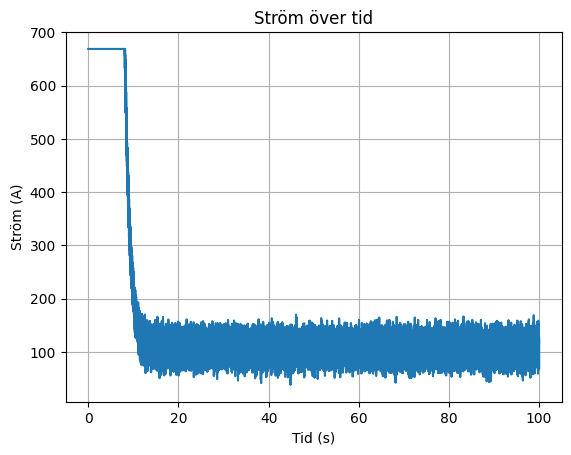

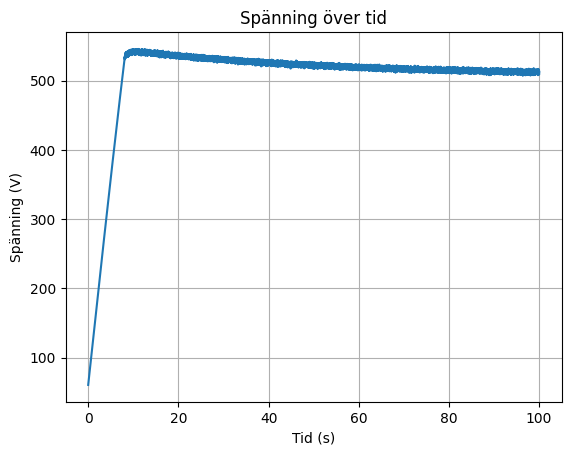

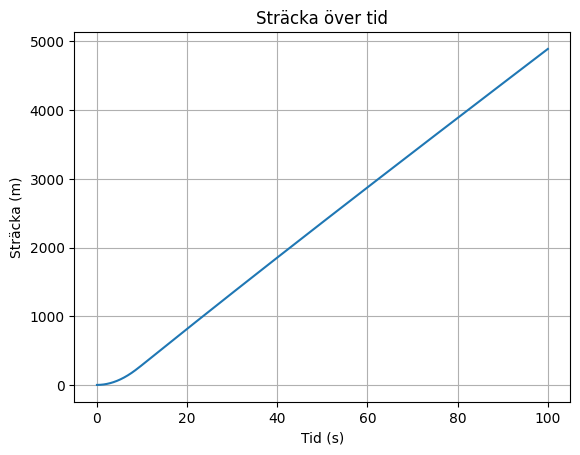

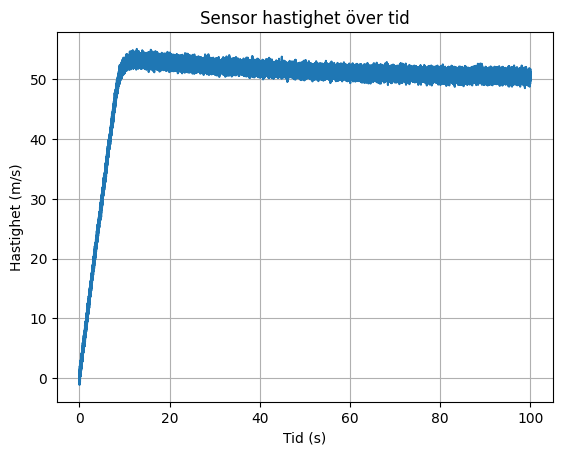

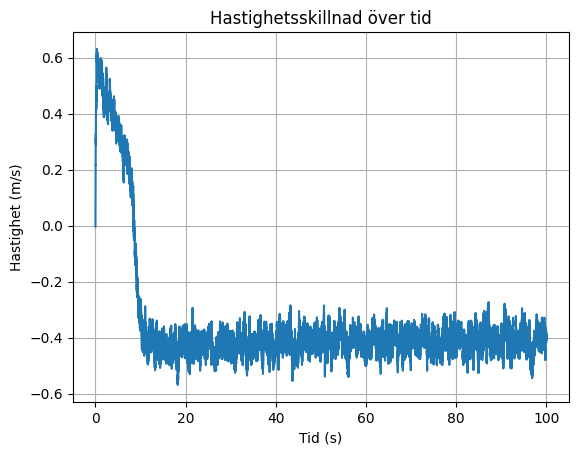

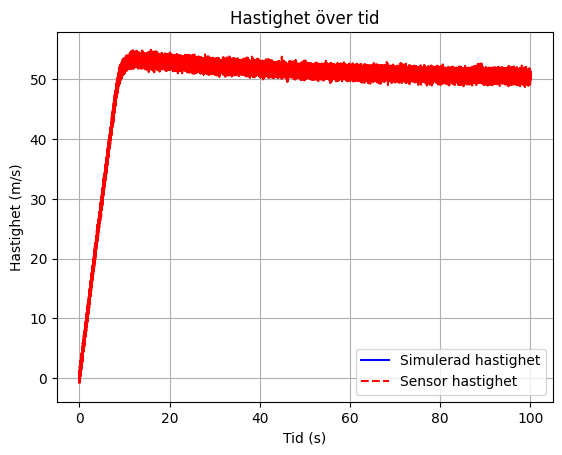

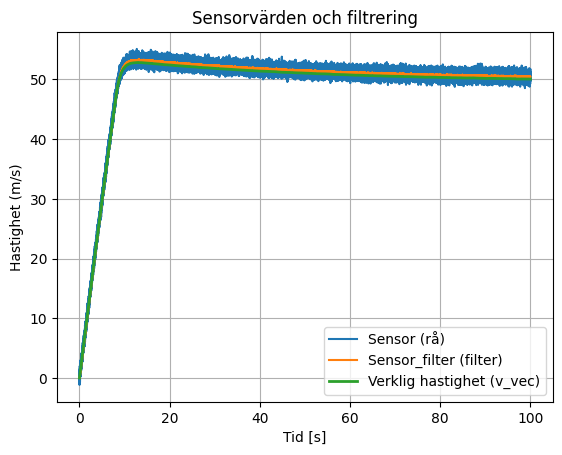

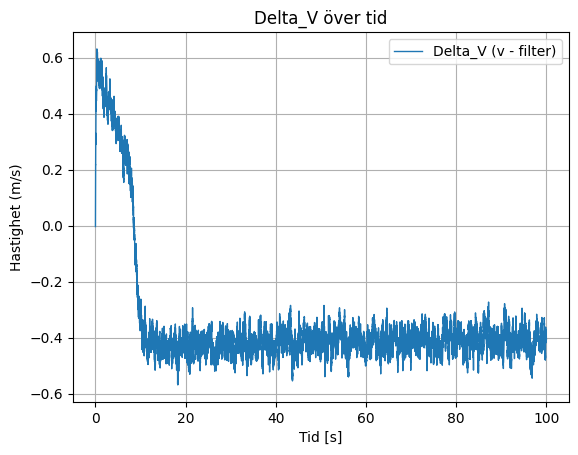

In [21]:
#=============================================================================
#-----------------------Simulering--------------------------------------------
#=============================================================================
#-----------------Simulering funktion-----------------------------------------
simtyp = 0                          #Variabel för att bestämma spänning- eller ström styrd
m = 1040                            #(kg) massan
alpha = 0                           #(grader) lutningen i radianer (grader * pi/180)
U = 2679                            #(v)
I = 669                             #(A)
noise = 0.5                         #Standardavvikelse för brus i sensorn
mf = np.random.uniform(-0.02, 0.02) #Fel i mätning
#representerar ett konstant kaliberingsfel
#Stts en gång när simuleringen startar 
#Är samma värde genom hela simuleringen
# ANVÄNDS FÖR ATT: 
#   Vi vet inte om sensor mäter för högt eller för lågt. 
#   Alla fel mellan 2 och -2 är lika troliga
#   ALLTSÅ VI VET INTE  HUR MYCKET SENSOR FELAR MEN FELET ÄR KONSTANT

fart = 50                           #(m/s) önskad hastighet
Reg_typ = 3                       #1 = P-regulator, 2 = PI-regulator, 3 = PID-regulator 

def sim(m,alpha, U, I):             #simulerig med insignalerna m, alpha, U, I
    N = 100000                      #Antal iterrationer
    dt = 0.001                      #(s) Tidsteg (start fråm 1ms)
    Kp = 90                      #Proportionalitets konstant för regulatorn
    Ki = 2                  #Integralkonstant för regulatorn
    Kd = 3                   #Derivata-konstant för regulatorn
    integral = 0                    #Integrerande term
    dervata = 0                     #Derivata term
    fel_start = 0                       #Antagande att fel från start är 0

#------------------Skapar vektorer för att lagra in resultat---------------------
    t_vec = np.zeros(N)             #tid                    ex.[0,0,....,0]
    v_vec = np.zeros(N)             #hastighet              ex.[0,0,....,0]
    a_vec = np.zeros(N)             #acceleration           ex.[0,0,....,0]
    ia_vec = np.zeros(N)            #ankarstörm             ex.[0,0,....,0]
    U_vec = np.zeros(N)             #spänning               ex.[0,0,....,0]
    s_vec = np.zeros(N)             #sträcka                ex.[0,0,....,0]
    Sensor = np.zeros(N)            #Sensor mätvärden       ex.[0,0,....,0]
    Delta_V = np.zeros(N)           #Skillnad mellan verklig och uppmätt hastighet
    Sensor_filter = np.zeros(N)

    for k in range(0,N):        #Från 0 till 999 (1000 iter.)

        t_vec[k]= k * dt                                #Sparar tiden för tillstånd k
        #Mekaniska krafter från omvärden som verkar på fordonet
        F_aero_1 = F_aero(v_vec[k])                     #Räknar luftmotsåndet i tillstånd k för hastigheten i det tillståndet
        F_roll_1 = F_roll(alpha, m)                     #Räknar friktion i tillstånd k för hastigheten i det tillståndet
        F_grad_1 = F_grad(alpha, m)                     #Räknar lutning i tillstånd k för hastigheten i det tillståndet
        F_motstånd = F_aero_1 + F_roll_1 + F_grad_1     #Totala motståndet som verkar på fordonet
        #Mekaniska kraften vi får från motorn

#--------------------------Sensor-------------------------------------

        Sensor[k] = (1 + mf) * v_vec[k] + np.random.normal(0, noise)  #Simulerar en sensor med brus och mätfel
        #normalfördelningför: 
        #   1. många små fel och de aderas ihop då blir resultatet normalfördelade. 
        #   2. Passar verkliga sensorer, det har visat sig med empirska mätningar att de flesta sensorer faktiskt har brus som följer normalfördelningen. 
        #   3. Enklt mattematiskt sätt, två variabler
    
        Sensor_filter[k] = 0.01 * Sensor[k] + 0.99*Sensor_filter[k-1] #Filterar sensorvärdet med ett filter
        Delta_V[k] = v_vec[k] - Sensor_filter[k]                             #Skillnaden i hastighet. 
        # I slumpmässiga sensorer finns alltid systematiska fel och slumpmässigt brus dvs varierande störningar
        #från elektronik mätningar
        fel = fart - Sensor_filter[k]                                        
        
#----------------------Beräkna styrsignal-----------------------------
        if Reg_typ == 1:       # P-regulator
            I_reg = Kp * fel
            U_reg = Kp * fel

        elif Reg_typ == 2:     # PI-regulator
            integral = integral + fel * dt
            I_reg = Kp * fel + Ki * integral
            if I_reg > I:
                I_reg = I
            U_reg = Kp * fel + Ki * integral

        elif Reg_typ == 3:     # PID-regulator
            integral = integral + fel * dt
            dervata = (fel-fel_start)/dt
            I_reg = Kp * fel + Ki * integral + Kd* dervata
            if I_reg > I:
                I_reg = I
            U_reg = Kp * fel + Ki * integral + Kd * dervata
        
        fel_start = fel                                               #Ersätt den tidigare fel med den nya
        #k=100: fel=2.0, fel_start=1.8 → dervata = (2.0-1.8)/0.001 = 200
        #fel_start = 2.0  (sparas till nästa)
        # #k=101: fel=2.1, fel_start=2.0 → dervata = (2.1-2.0)/0.001 = 100
        #fel_start = 2.1  (sparas till nästa)
            
#----------------------------------Styrning----------------------------            
        if simtyp==1:                                            #Fallet spänningstyrd

            ia_vec[k] = (U_reg - lamda * w_r(v_vec[k]))/Ra       
            if ia_vec[k] > I:                                    #Begränsar strömmen till max ström
                ia_vec[k] = I 
            U_vec[k] =  U_reg

        else:                                               #Strömstyrd
            U_vec[k] = I_reg * Ra + lamda * w_r(v_vec[k])       #Sparar värden för späningen för varje tillstånd
            if U_vec[k] > U:                                #Begränsar spänningen till max spänning
                U_vec[k] = U
            U_vec[k] = min(U_vec[k], U)
            ia_vec[k] = I_reg                                    #Sparar värden för strömmen för varje tillstånd

       
       
        T_hjul = n*(T_e(ia_vec[k])-T_f)/i                   #(Nm) Räknar hjulensvridmoment beroende av strömmen

        F_trac = T_hjul/r_hjul                              #(N) Dragkraften vid hjulen

        F_net = F_trac - F_motstånd                         #(N) Nettokraften som får fordonet att röra sig

        a = F_net/m                                         #(m/s^2) Accelerationen

        if a > (mu * g * np.cos(alpha)):                    #Kollar om accelerationen är större än max acceleration
            a = mu * g * np.cos(alpha)                      #Sätter accelerationen till max acceleration
        a_vec[k] = a                                        #Sparar accelerationen i vektorn

        if k < (N - 1):
            v_vec[k+1] = v_vec[k] + (a * dt)                #(Eulers-metod) Sparar hastigheten i nästa tillstånd
            #S = v * t + (a*t^2)/2
            s_vec[k+1] = s_vec[k] + (v_vec[k] * dt) + (a * (dt**2)) / 2 #Sparar sträckan i nästa tillstånd
   
#------------------------------------Plotar vektorerna -------------------------------
    #0 = ingen graf, 1 = fem separata, 2 = en sammanställd
    toggle = 1   #Ändra denna om du vill byta graf
    if toggle == 1:
        plt.plot(t_vec,v_vec)
        plt.title("Hastighet över tid")
        plt.xlabel("Tid (s)")
        plt.ylabel("Hastighet (m/s)")
        plt.grid(True)
        plt.show()

        plt.plot(t_vec,a_vec)
        plt.title("Acceleration över tid")
        plt.xlabel("Tid (s)")
        plt.ylabel("Acceleration (m/s^2)")
        plt.grid(True)
        plt.show()

        plt.plot(t_vec,ia_vec)
        plt.title("Ström över tid")
        plt.xlabel("Tid (s)")
        plt.ylabel("Ström (A)")
        plt.grid(True)
        plt.show()
       
        plt.plot(t_vec,U_vec)
        plt.title("Spänning över tid")
        plt.xlabel("Tid (s)")
        plt.ylabel("Spänning (V)")
        plt.grid(True)
        plt.show()

        plt.plot(t_vec,s_vec)
        plt.title("Sträcka över tid")
        plt.xlabel("Tid (s)")
        plt.ylabel("Sträcka (m)")
        plt.grid(True)
        plt.show()

        plt.plot(t_vec,Sensor)
        plt.title("Sensor hastighet över tid")
        plt.xlabel("Tid (s)")
        plt.ylabel("Hastighet (m/s)")
        plt.grid(True)
        plt.show()

        plt.plot(t_vec,Delta_V)
        plt.title("Hastighetsskillnad över tid")
        plt.xlabel("Tid (s)")
        plt.ylabel("Hastighet (m/s)")
        plt.grid(True)
        plt.show()

        plt.plot(t_vec, v_vec, color='blue', label='Simulerad hastighet')
        plt.plot(t_vec, Sensor, color='red', linestyle='--', label='Sensor hastighet')
        plt.title("Hastighet över tid")
        plt.xlabel("Tid (s)")
        plt.ylabel("Hastighet (m/s)")
        plt.legend()      # visar en förklarande ruta
        plt.grid(True)    # gör grafen lättare att läsa
        plt.show()

        plt.plot(t_vec, Sensor, label="Sensor (rå)")
        plt.plot(t_vec, Sensor_filter, label="Sensor_filter (filter)")
        plt.plot(t_vec, v_vec, label="Verklig hastighet (v_vec)", linewidth=2)
        plt.xlabel("Tid [s]")
        plt.ylabel("Hastighet (m/s)")
        plt.title("Sensorvärden och filtrering")
        plt.grid(True)
        plt.legend()
        plt.show()

        plt.plot(t_vec, Delta_V, label="Delta_V (v - filter)", linewidth=1)
        plt.xlabel("Tid [s]")
        plt.ylabel("Hastighet (m/s)")
        plt.title("Delta_V över tid")
        plt.grid(True)
        plt.legend()
        plt.show()


    #Om man vill ha allt i en graf:
    if toggle == 2:
        plt.plot(t_vec, v_vec, label="Hastighet")
        plt.plot(t_vec, a_vec, label="Acceleration")
        plt.plot(t_vec, ia_vec, label="Ström")
        plt.plot(t_vec, U_vec, label="Spänning")
        plt.plot(t_vec, s_vec, label="Sträcka")
        plt.title("Sammanställd graf")
        plt.xlabel("Tid (s)")
        plt.ylabel("Mätdata")
        plt.legend()
        plt.grid(True)
        plt.show()
sim(m, alpha, U, I)


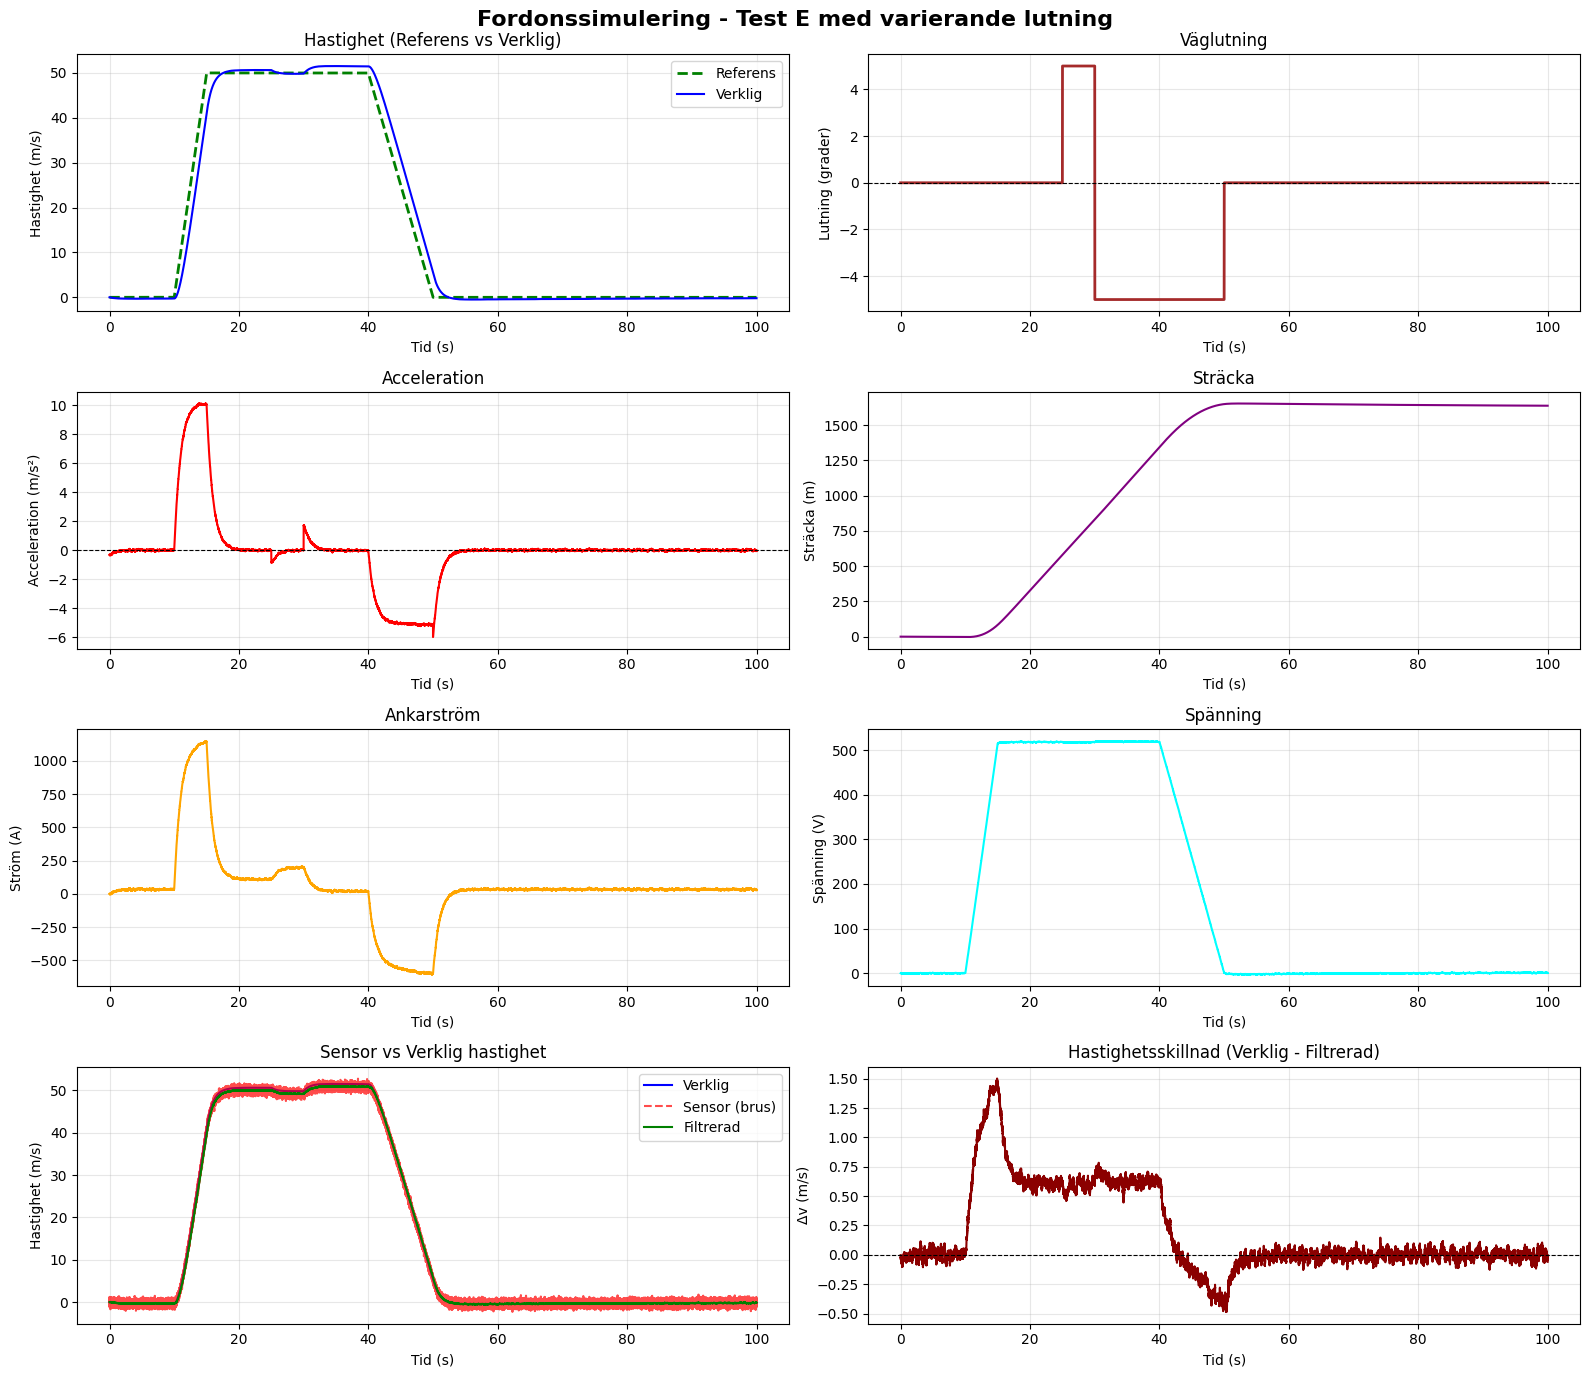

In [22]:
def refsignal_och_lutning (N, dt):
    N = 100000                              #Antal iterrationer
    dt = 0.001                              #Tidssteg 
    #------- skapar nya vektorer---------------
    t_vec_ref = np.arange(0,N*dt,dt)        #ref. tid                    ex.[0,0,....,0]
    v_ref = np.zeros(N)                     #ref. hastighet              ex.[0,0,....,0]
    alpha_vec = np.zeros(N)                 #Vägluningen                 ex.[0,0,....,0]
    #---------------------------------------------
    for k in range(N): 
        t = t_vec_ref[k] 
        if t < 10:                          #Fas 1: Stillastående (0 - 10)s
            v_ref[k] = 0
            alpha_vec[k] = 0
        elif t < 15:                        #Fas 2: Acceleration (10-15s) - accelerera till 50 m/s på 5s
            acceleration = 10               #(m/s^2) 
            v_ref[k] = acceleration * (t - 10)  #(m/s) Hastigheten 50 m/s
            alpha_vec[k] = 0                #luntingen 0
        elif t < 25:                        # Fas 3: Konstant fart horisontell väg (15-25s)
            v_ref[k] = 50
            alpha_vec[k] = 0
        elif t < 30:                        # Fas 4: Uppförsbacke 5 grader (25-30s)
            v_ref[k] = 50
            alpha_vec[k] = 5 * np.pi/180    #(grader) till radianer
        elif t < 40:                        # Fas 5: Nedförsbacke -5 grader (30-40s)
            v_ref[k] = 50
            alpha_vec[k] = -5 * np.pi/180   #(grader) till radianer
        elif t < 50:                        # Fas 6: Decelerering (40-50s)
            decceleration = -5              #(m/s^2)
            v_ref[k] = max(0, decceleration * (t - 40) + 50)
            alpha_vec[k] = -5 * np.pi/180   #(grader) till radianer
        else:
            v_ref[k] = 0
            alpha_vec[k] = 0
    
    return v_ref, alpha_vec

#=============================================================================
#-----------------------Simulering--------------------------------------------
#=============================================================================
#-----------------Simulering funktion-----------------------------------------
simtyp = 0                          #Variabel för att bestämma spänning- eller ström styrd
m = 1040                            #(kg) massan
alpha = 0                           #(grader) lutningen i radianer (grader * pi/180)
U = 2679                            #(v)
I = 669                             #(A)
noise = 0.5                         #Standardavvikelse för brus i sensorn
mf = np.random.uniform(-0.02, 0.02) #Fel i mätning
fart = 50                           #(m/s) önskad hastighet
Reg_typ = 2                         #1 = P-regulator, 2 = PI-regulator, 3 = PID-regulator
fel_start = 0                       #Antagande att fel från start är 0 

def sim(m, U, I, körtest_E=False):  #simulering med insignalerna m, U, I
    N = 100000                      #Antal iterrationer
    dt = 0.001                      #(s) Tidsteg (start fråm 1ms)
    
    #--------------------Skapa referenssignal och lutning för test E-------------------------------
    if körtest_E:                       
        v_ref_vec, alpha_vec = refsignal_och_lutning(N, dt)
    else:                               #Gäller från del D
        v_ref_vec = np.ones(N) * fart   #Konstant referenshastighet
        alpha_vec = np.ones(N) * alpha  #Konstant lutning
    #---------------------------------------------------------------------------------------------
    Kp = 100                        #Proportionalitets konstant för regulatorn
    Ki = 2                          #Integralkonstant för regulatorn
    KD = 0                        #Derivata-konstant för regulatorn
    integral = 0                    #Integrerande term
    dervata = 0                     #Derivata term
    #------------------Skapar vektorer för att lagra in resultat---------------------
    t_vec = np.zeros(N)             #tid                    ex.[0,0,....,0]
    v_vec = np.zeros(N)             #hastighet              ex.[0,0,....,0]
    a_vec = np.zeros(N)             #acceleration           ex.[0,0,....,0]
    ia_vec = np.zeros(N)            #ankarstörm             ex.[0,0,....,0]
    U_vec = np.zeros(N)             #spänning               ex.[0,0,....,0]
    s_vec = np.zeros(N)             #sträcka                ex.[0,0,....,0]
    Sensor = np.zeros(N)            #Sensor mätvärden       ex.[0,0,....,0]
    Delta_V = np.zeros(N)           #Skillnad mellan verklig och uppmätt hastighet
    sensor_filter = np.zeros(N)     #Sensor filtering för att minimera brus
    #------------------------------------------------------------------------------------
    for k in range(0,N):        #Från 0 till 999 (1000 iter.)

        t_vec[k]= k * dt                                #Sparar tiden för tillstånd k
        
        #Dynamisk lutning från alpha_vec
        alpha_k = alpha_vec[k]                          #Hämta lutning för detta tidssteg
        
        #Mekaniska krafter från omvärden som verkar på fordonet
        F_aero_1 = F_aero(v_vec[k])                     #Räknar luftmotsåndet i tillstånd k för hastigheten i det tillståndet
        F_roll_1 = F_roll(alpha_k, m)                   #Räknar friktion i tillstånd k för hastigheten i det tillståndet
        F_grad_1 = F_grad(alpha_k, m)                   #Räknar lutning i tillstånd k för hastigheten i det tillståndet
        F_motstånd = F_aero_1 + F_roll_1 + F_grad_1     #Totala motståndet som verkar på fordonet

    #--------------------------Sensor-------------------------------------

        Sensor[k] = (1 + mf) * v_vec[k] + np.random.normal(0, noise)         #Förändringen i hastighet ? + felet i mätningen ? VARFÖR
        sensor_filter[k] = 0.01 * Sensor[k] + 0.99*sensor_filter[k-1]        #Vi tar 1% av sensor, sen 99% av sensor filter 
        Delta_V[k] = v_vec[k] - sensor_filter[k]                             #Skillnaden i hastighet. 
        
        fel = v_ref_vec[k] - sensor_filter[k]                                #Beräkna fel mot referenshastighet
        fel_start = fel                                                      #Ersätt den tidigare fel med den nya
        
    #----------------------Beräkna styrsignal-----------------------------
        if Reg_typ == 1:       # P-regulator
            I_reg = Kp * fel
            U_reg = Kp * fel

        elif Reg_typ == 2:     # PI-regulator
            integral = integral + fel * dt
            I_reg = Kp * fel + Ki * integral
            U_reg = Kp * fel + Ki * integral

        elif Reg_typ == 3:     # PID-regulator
            integral = integral + fel * dt
            dervata = (fel-fel_start)/dt
            I_reg = Kp * fel + Ki * integral + KD * dervata
            if I_reg > I:      #Begränsar strömen i regulatorn
                I_reg = I
            U_reg = Kp * fel + Ki * integral + KD * dervata
            
            
    #----------------------------------Styrning----------------------------            
        if simtyp==1:                                            #Fallet spänningstyrd

            ia_vec[k] = (U_reg - lamda * w_r(v_vec[k]))/Ra       
            if ia_vec[k] > I:                                    #Begränsar strömmen till max ström
                ia_vec[k] = I 
            U_vec[k] =  U_reg

        else:                                               #Strömstyrd
            U_vec[k] = I_reg * Ra + lamda * w_r(v_vec[k])       #Sparar värden för späningen för varje tillstånd
            if U_vec[k] > U:                                #Begränsar spänningen till max spänning
                U_vec[k] = U
            U_vec[k] = min(U_vec[k], U)
            ia_vec[k] = I_reg                                    #Sparar värden för strömmen för varje tillstånd

       
       
        T_hjul = n*(T_e(ia_vec[k])-T_f)/i                   #(Nm) Räknar hjulensvridmoment beroende av strömmen

        F_trac = T_hjul/r_hjul                              #(N) Dragkraften vid hjulen

        F_net = F_trac - F_motstånd                         #(N) Nettokraften som får fordonet att röra sig

        a = F_net/m                                         #(m/s^2) Accelerationen

        # Använd dynamisk lutning för max acceleration
        if a > (mu * g * np.cos(alpha_k)):                  #Kollar om accelerationen är större än max acceleration
            a = mu * g * np.cos(alpha_k)                    #Sätter accelerationen till max acceleration
        a_vec[k] = a                                        #Sparar accelerationen i vektorn

        if k < (N - 1):
            v_vec[k+1] = v_vec[k] + (a * dt)                #(Eulers-metod) Sparar hastigheten i nästa tillstånd
            #S = v * t + (a*t^2)/2
            s_vec[k+1] = s_vec[k] + (v_vec[k] * dt) + (a * (dt**2)) / 2 #Sparar sträckan i nästa tillstånd
    #------------------------------------Plotar vektorerna -------------------------------
    #0 = ingen graf, 1 = separata fönster, 2 = subplots (rekommenderas!), 3 = allt i en graf
    toggle = 2   #Ändra denna om du vill byta plotstil
    
    if toggle == 1:
        # SEPARATA FÖNSTER - Varje graf i eget fönster
        plt.plot(t_vec,v_vec)
        plt.title("Hastighet över tid")
        plt.xlabel("Tid (s)")
        plt.ylabel("Hastighet (m/s)")
        plt.grid(True)
        plt.show()

        plt.plot(t_vec,a_vec)
        plt.title("Acceleration över tid")
        plt.xlabel("Tid (s)")
        plt.ylabel("Acceleration (m/s^2)")
        plt.grid(True)
        plt.show()

        plt.plot(t_vec,ia_vec)
        plt.title("Ström över tid")
        plt.xlabel("Tid (s)")
        plt.ylabel("Ström (A)")
        plt.grid(True)
        plt.show()
       
        plt.plot(t_vec,U_vec)
        plt.title("Spänning över tid")
        plt.xlabel("Tid (s)")
        plt.ylabel("Spänning (V)")
        plt.grid(True)
        plt.show()

        plt.plot(t_vec,s_vec)
        plt.title("Sträcka över tid")
        plt.xlabel("Tid (s)")
        plt.ylabel("Sträcka (m)")
        plt.grid(True)
        plt.show()
        
        if körtest_E:
            plt.plot(t_vec, v_ref_vec, color='green', linestyle='--', label='Referenshastighet', linewidth=2)
            plt.plot(t_vec, v_vec, color='blue', label='Verklig hastighet')
            plt.title("Hastighet över tid - Test E")
            plt.xlabel("Tid (s)")
            plt.ylabel("Hastighet (m/s)")
            plt.legend()
            plt.grid(True)
            plt.show()
            
            plt.plot(t_vec, alpha_vec * 180/np.pi)
            plt.title("Väglutning över tid")
            plt.xlabel("Tid (s)")
            plt.ylabel("Lutning (grader)")
            plt.grid(True)
            plt.show()
    
    elif toggle == 2:
        # SUBPLOTS - Alla grafer i ett rutnät (REKOMMENDERAS!)
        if körtest_E:
            # För Test E: 4x2 rutnät (8 grafer)
            fig, axes = plt.subplots(4, 2, figsize=(16, 14))
            fig.suptitle('Fordonssimulering - Test E med varierande lutning', fontsize=16, fontweight='bold')
            
            # Rad 1, kolumn 1: Referenshastighet vs Verklig
            axes[0, 0].plot(t_vec, v_ref_vec, color='green', linestyle='--', label='Referens', linewidth=2)
            axes[0, 0].plot(t_vec, v_vec, color='blue', label='Verklig', linewidth=1.5)
            axes[0, 0].set_title('Hastighet (Referens vs Verklig)')
            axes[0, 0].set_xlabel('Tid (s)')
            axes[0, 0].set_ylabel('Hastighet (m/s)')
            axes[0, 0].legend()
            axes[0, 0].grid(True, alpha=0.3)
            
            # Rad 1, kolumn 2: Väglutning
            axes[0, 1].plot(t_vec, alpha_vec * 180/np.pi, color='brown', linewidth=2)
            axes[0, 1].set_title('Väglutning')
            axes[0, 1].set_xlabel('Tid (s)')
            axes[0, 1].set_ylabel('Lutning (grader)')
            axes[0, 1].grid(True, alpha=0.3)
            axes[0, 1].axhline(y=0, color='black', linestyle='--', linewidth=0.8)
            
            # Rad 2, kolumn 1: Acceleration
            axes[1, 0].plot(t_vec, a_vec, color='red', linewidth=1.5)
            axes[1, 0].set_title('Acceleration')
            axes[1, 0].set_xlabel('Tid (s)')
            axes[1, 0].set_ylabel('Acceleration (m/s²)')
            axes[1, 0].grid(True, alpha=0.3)
            axes[1, 0].axhline(y=0, color='black', linestyle='--', linewidth=0.8)
            
            # Rad 2, kolumn 2: Sträcka
            axes[1, 1].plot(t_vec, s_vec, color='purple', linewidth=1.5)
            axes[1, 1].set_title('Sträcka')
            axes[1, 1].set_xlabel('Tid (s)')
            axes[1, 1].set_ylabel('Sträcka (m)')
            axes[1, 1].grid(True, alpha=0.3)
            
            # Rad 3, kolumn 1: Ström
            axes[2, 0].plot(t_vec, ia_vec, color='orange', linewidth=1.5)
            axes[2, 0].set_title('Ankarström')
            axes[2, 0].set_xlabel('Tid (s)')
            axes[2, 0].set_ylabel('Ström (A)')
            axes[2, 0].grid(True, alpha=0.3)
            
            # Rad 3, kolumn 2: Spänning
            axes[2, 1].plot(t_vec, U_vec, color='cyan', linewidth=1.5)
            axes[2, 1].set_title('Spänning')
            axes[2, 1].set_xlabel('Tid (s)')
            axes[2, 1].set_ylabel('Spänning (V)')
            axes[2, 1].grid(True, alpha=0.3)
            
            # Rad 4, kolumn 1: Sensor vs Verklig hastighet
            axes[3, 0].plot(t_vec, v_vec, color='blue', label='Verklig', linewidth=1.5)
            axes[3, 0].plot(t_vec, Sensor, color='red', linestyle='--', alpha=0.7, label='Sensor (brus)')
            axes[3, 0].plot(t_vec, sensor_filter, color='green', linewidth=1.5, label='Filtrerad')
            axes[3, 0].set_title('Sensor vs Verklig hastighet')
            axes[3, 0].set_xlabel('Tid (s)')
            axes[3, 0].set_ylabel('Hastighet (m/s)')
            axes[3, 0].legend()
            axes[3, 0].grid(True, alpha=0.3)
            
            # Rad 4, kolumn 2: Hastighetsskillnad (fel)
            axes[3, 1].plot(t_vec, Delta_V, color='darkred', linewidth=1.5)
            axes[3, 1].set_title('Hastighetsskillnad (Verklig - Filtrerad)')
            axes[3, 1].set_xlabel('Tid (s)')
            axes[3, 1].set_ylabel('Δv (m/s)')
            axes[3, 1].grid(True, alpha=0.3)
            axes[3, 1].axhline(y=0, color='black', linestyle='--', linewidth=0.8)
            
        else:
            # För vanlig simulering: 3x2 rutnät (6 grafer)
            fig, axes = plt.subplots(3, 2, figsize=(16, 10))
            fig.suptitle('Fordonssimulering - Standardläge', fontsize=16, fontweight='bold')
            
            # Hastighet
            axes[0, 0].plot(t_vec, v_vec, color='blue', linewidth=1.5)
            axes[0, 0].set_title('Hastighet')
            axes[0, 0].set_xlabel('Tid (s)')
            axes[0, 0].set_ylabel('Hastighet (m/s)')
            axes[0, 0].grid(True, alpha=0.3)
            
            # Acceleration
            axes[0, 1].plot(t_vec, a_vec, color='red', linewidth=1.5)
            axes[0, 1].set_title('Acceleration')
            axes[0, 1].set_xlabel('Tid (s)')
            axes[0, 1].set_ylabel('Acceleration (m/s²)')
            axes[0, 1].grid(True, alpha=0.3)
            
            # Ström
            axes[1, 0].plot(t_vec, ia_vec, color='orange', linewidth=1.5)
            axes[1, 0].set_title('Ankarström')
            axes[1, 0].set_xlabel('Tid (s)')
            axes[1, 0].set_ylabel('Ström (A)')
            axes[1, 0].grid(True, alpha=0.3)
            
            # Spänning
            axes[1, 1].plot(t_vec, U_vec, color='cyan', linewidth=1.5)
            axes[1, 1].set_title('Spänning')
            axes[1, 1].set_xlabel('Tid (s)')
            axes[1, 1].set_ylabel('Spänning (V)')
            axes[1, 1].grid(True, alpha=0.3)
            
            # Sträcka
            axes[2, 0].plot(t_vec, s_vec, color='purple', linewidth=1.5)
            axes[2, 0].set_title('Sträcka')
            axes[2, 0].set_xlabel('Tid (s)')
            axes[2, 0].set_ylabel('Sträcka (m)')
            axes[2, 0].grid(True, alpha=0.3)
            
            # Sensor
            axes[2, 1].plot(t_vec, v_vec, color='blue', label='Verklig', linewidth=1.5)
            axes[2, 1].plot(t_vec, Sensor, color='red', linestyle='--', alpha=0.7, label='Sensor')
            axes[2, 1].set_title('Hastighet (Verklig vs Sensor)')
            axes[2, 1].set_xlabel('Tid (s)')
            axes[2, 1].set_ylabel('Hastighet (m/s)')
            axes[2, 1].legend()
            axes[2, 1].grid(True, alpha=0.3)
        
        plt.tight_layout()
        plt.show()
    
    elif toggle == 3:
        # ALLT I EN GRAF - Alla kurvor överlagrade (inte rekommenderat)
        plt.figure(figsize=(14, 8))
        plt.plot(t_vec, v_vec, label="Hastighet (m/s)", linewidth=2)
        plt.plot(t_vec, a_vec, label="Acceleration (m/s²)", linewidth=2)
        plt.plot(t_vec, ia_vec/100, label="Ström (A/100)", linewidth=2)
        plt.plot(t_vec, U_vec/1000, label="Spänning (kV)", linewidth=2)
        plt.plot(t_vec, s_vec/100, label="Sträcka (100m)", linewidth=2)
        if körtest_E:
            plt.plot(t_vec, alpha_vec * 180/np.pi * 10, label="Lutning (10×grader)", linewidth=2)
        plt.title("Sammanställd graf - Alla parametrar", fontsize=14, fontweight='bold')
        plt.xlabel("Tid (s)")
        plt.ylabel("Skalerade värden")
        plt.legend(loc='best')
        plt.grid(True, alpha=0.3)
        plt.show()

sim(m, U, I, körtest_E=True)

In [23]:
#Skrievr ut effekter


def effektflöden(v, alpha):

    #Krafter
    F_a = F_aero(v)
    F_r = F_roll(alpha, m)
    F_g = F_grad(alpha, m)
    F_motstånd = F_a + F_r + F_g          

    #För konstant fart: nettokraft = 0 => F_trac = F_motstånd (blir negativ i nedförsbacke om backe är "brant" nog)

    F_trac = F_motstånd

    #Motorvarvtal och moment
    w = w_r(v)                             #(rad/s) 
    ia = (F_trac * r_hjul * i / n + T_f) / lamda   #Löst ur T_hjul = n*(lamda*ia - T_f)/i
    Te = T_e(ia)

    #Elektriskt (100% verkningsgrad i kraftelektronik)
    U_el = Ra * ia + lamda * w             #u = R_a i_a + λ ω
    P_el = U_el * ia                       #Effekt mellan batteri och kraftelektronik

    #Mekaniska effekter
    P_dev_mech    = Te * w                 #Mekanisk effekt i motorn
    P_motor_shaft = (Te - T_f) * w         #Efter friktionsmomentet T_f (axeleffekt)
    P_hjul        = F_trac * v             #Effekt vid hjulen

    #Förluster i drivlinan
    P_cu        = ia**2 * Ra              #Kopparförlust
    P_fric      = T_f * w                 #Friktionsförlust i motor
    P_gear_loss = (1 - n) * P_motor_shaft #Växelförlust (tecken följer effektriktningen)

    #Vägmotståndens effekter
    P_aero  = F_a * v
    P_roll  = F_r * v
    P_grad  = F_g * v

    return {
        "v": v,
        "alpha": alpha,
        "F_trac": F_trac,
        "P_el": P_el,
        "P_motor_shaft": P_motor_shaft,
        "P_hjul": P_hjul,
        "P_cu": P_cu,
        "P_fric": P_fric,
        "P_gear_loss": P_gear_loss,
        "P_aero": P_aero,
        "P_roll": P_roll,
        "P_grad": P_grad,
    }

v_max = 150   #Önskat v_max inför effektberäkning

#Case 1: 10% av v_max
case_1 = effektflöden(0.1 * v_max, 0.0)

#Case 2: 100% av v_max
case_2 = effektflöden(v_max, 0.0)

#Case 3: 100% av v_max, lutning så pass stor att motor blir generator
alpha_brant = -45 * np.pi/180     #Gör om rad till grader, ändra denna för att ändra vinkel i smulering!
case_3 = effektflöden(v_max, alpha_brant)

cases = {"v = 10% v_max": case_1,
         "v = 100% v_max": case_2,
         "v = 100% v_max, lutning -10 grader": case_3}

#Skriver ut sammanfattning (W)
for namn, c in cases.items():
    print(namn)
    print()
    print(f" v = {c['v']:.1f} m/s, alpha = {c['alpha']*180/np.pi:.1f}°")
    print(f" P_el (batteri)                 = {c['P_el']:.1f} W")
    print(f" P_motor_axel                   = {c['P_motor_shaft']:.1f} W")
    print(f" P_hjul                         = {c['P_hjul']:.1f} W")
    print(f"  - P_Cu                        = {c['P_cu']:.1f} W")
    print(f"  - P_fric                      = {c['P_fric']:.1f} W")
    print(f"  - P_växel                     = {c['P_gear_loss']:.1f} W")
    print(f"  - P_aero (luftmotstånd)       = {c['P_aero']:.1f} W")
    print(f"  - P_roll (rullmotstånd)       = {c['P_roll']:.1f} W")
    print(f"  - P_grad (kraft vid lutning   = {c['P_grad']:.1f} W")
    print()



v = 10% v_max

 v = 15.0 m/s, alpha = 0.0°
 P_el (batteri)                 = 6067.7 W
 P_motor_axel                   = 5688.4 W
 P_hjul                         = 5586.0 W
  - P_Cu                        = 140.6 W
  - P_fric                      = 238.7 W
  - P_växel                     = 102.4 W
  - P_aero (luftmotstånd)       = 990.2 W
  - P_roll (rullmotstånd)       = 4595.8 W
  - P_grad (kraft vid lutning   = 0.0 W

v = 100% v_max

 v = 150.0 m/s, alpha = 0.0°
 P_el (batteri)                 = 1102331.6 W
 P_motor_axel                   = 1055175.8 W
 P_hjul                         = 1036182.6 W
  - P_Cu                        = 44769.2 W
  - P_fric                      = 2386.7 W
  - P_växel                     = 18993.2 W
  - P_aero (luftmotstånd)       = 990225.0 W
  - P_roll (rullmotstånd)       = 45957.6 W
  - P_grad (kraft vid lutning   = 0.0 W

v = 100% v_max, lutning -10 grader

 v = 150.0 m/s, alpha = -45.0°
 P_el (batteri)                 = -59091.1 W
 P_motor_axel       

Ignoring fixed y limits to fulfill fixed data aspect with adjustable data limits.


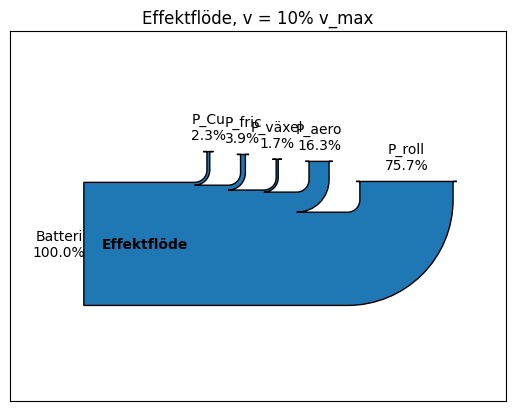

Ignoring fixed y limits to fulfill fixed data aspect with adjustable data limits.


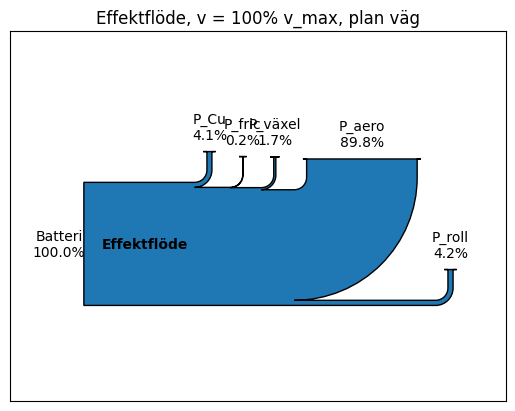

Ignoring fixed y limits to fulfill fixed data aspect with adjustable data limits.


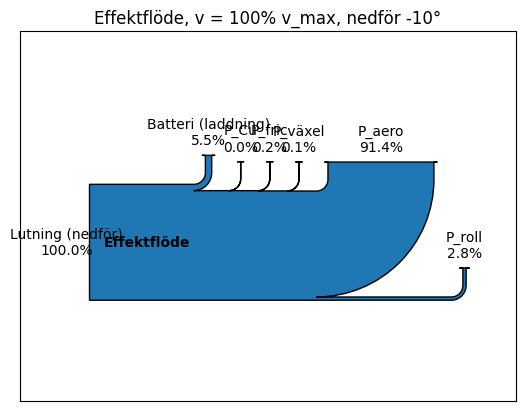

In [24]:
#Sankeydiagram

import matplotlib.pyplot as plt
from matplotlib.sankey import Sankey

def plot_sankey(c, titel="Effektflödesdiagram"):
    # Plocka ut alla effekter
    P_batt = c["P_el"]
    P_cu   = c["P_cu"]
    P_fric = c["P_fric"]
    P_gear = abs(c["P_gear_loss"])  # tar absolutbelopp, tecknet visar bara riktning i din modell
    P_aero = c["P_aero"]
    P_roll = c["P_roll"]
    P_grad = c["P_grad"]

    # Bygg lista med (namn, storlek, riktning) där riktning är 'in' till drivlinan eller 'out'
    terms = []

    # Batteri: om P_el > 0: effekt *från* batteriet *in* i drivlinan
    #          om P_el < 0: effekt *ut* ur drivlinan *tillbaka* till batteri (regenerering)
    if P_batt > 0:
        terms.append(("Batteri", P_batt, "in"))
    elif P_batt < 0:
        terms.append(("Batteri (laddning)", -P_batt, "out"))

    # Gravitation: uppför (P_grad > 0) = förlust / ut från drivlinan
    #              nedför  (P_grad < 0) = källa / in till drivlinan
    if P_grad > 0:
        terms.append(("Lutning (uppför)", P_grad, "out"))
    elif P_grad < 0:
        terms.append(("Lutning (nedför)", -P_grad, "in"))

    # Övriga är alltid förluster utsidan av drivlinan
    terms.append(("P_Cu",   P_cu,   "out"))
    terms.append(("P_fric", P_fric, "out"))
    terms.append(("P_växel", P_gear, "out"))
    terms.append(("P_aero", P_aero, "out"))
    terms.append(("P_roll", P_roll, "out"))

    # Summera in- respektive ut-effekter
    P_in_total  = sum(P for _, P, d in terms if d == "in")
    P_out_total = sum(P for _, P, d in terms if d == "out")

    # Om det differerar lite p.g.a avrundningar i dina modeller, så hanterar vi det i sista flödet
    # Normalisera alla flöden till procent av P_in_total
    flows = []
    labels = []
    orientations = []

    for name, P, direction in terms:
        if P_in_total == 0:
            continue  # skydd om något är jättekonstigt
        val = 100.0 * P / P_in_total
        if direction == "in":
            flows.append(val)      # in => positivt
            orientations.append(0) # pilriktning (kan ändras efter smak)
        else:
            flows.append(-val)     # ut => negativt
            orientations.append(1)
        labels.append(name)

    # Justera sista flödet så att summan blir exakt noll (krav i Sankey)
    flows[-1] = -sum(flows[:-1])

    # Rita Sankey
    fig = plt.figure()
    ax = fig.add_subplot(1, 1, 1, xticks=[], yticks=[], title=titel)

    sankey = Sankey(ax=ax, scale=0.01, offset=0.2, head_angle=180,
                    format='%.1f', unit='%')

    sankey.add(
        flows=flows,
        labels=labels,
        orientations=orientations,
        pathlengths=[0.25] * len(flows),
        patchlabel="Effektflöde",
    )

    diagrams = sankey.finish()
    diagrams[0].text.set_fontweight('bold')
    plt.show()

plot_sankey(case_1, "Effektflöde, v = 10% v_max")
plot_sankey(case_2, "Effektflöde, v = 100% v_max, plan väg")
plot_sankey(case_3, "Effektflöde, v = 100% v_max, nedför -10°")

AttributeError: 'types.SimpleNamespace' object has no attribute 'patches'

Ignoring fixed y limits to fulfill fixed data aspect with adjustable data limits.


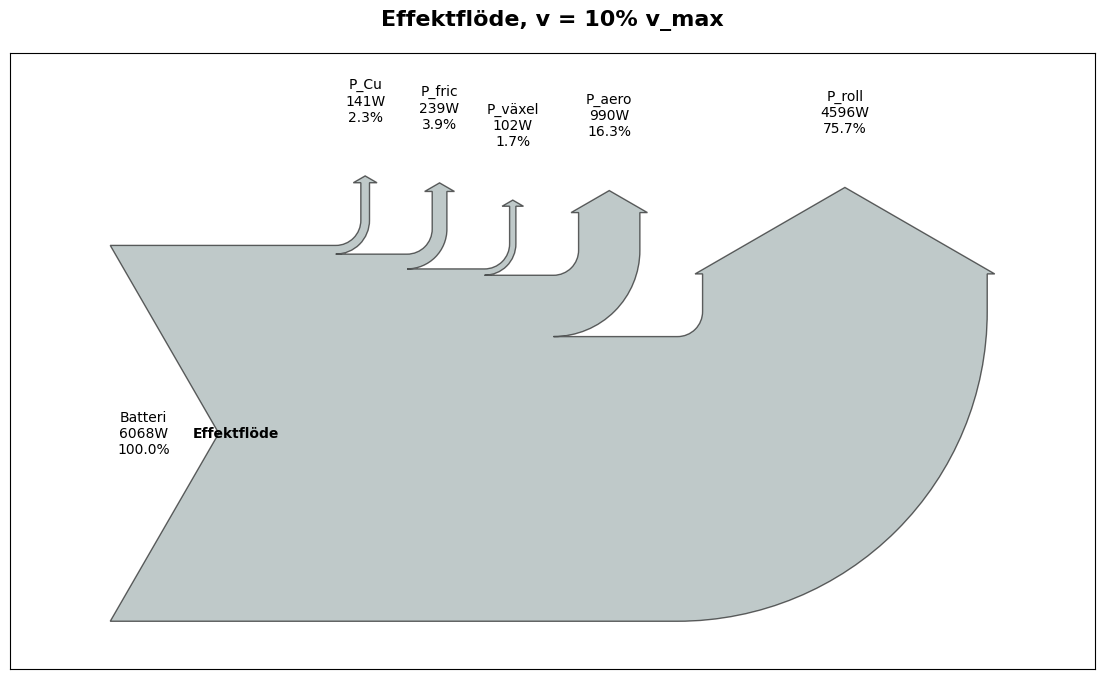

In [29]:
def plot_sankey_improved(c, titel="Effektflödesdiagram"):
    """Förbättrad version med färger och bättre layout"""
    P_batt = c["P_el"]
    P_cu   = c["P_cu"]
    P_fric = c["P_fric"]
    P_gear = abs(c["P_gear_loss"])
    P_aero = c["P_aero"]
    P_roll = c["P_roll"]
    P_grad = c["P_grad"]

    terms = []

    if P_batt > 0:
        terms.append(("Batteri", P_batt, "in"))
    elif P_batt < 0:
        terms.append(("Regenerering", -P_batt, "out"))

    if P_grad > 0:
        terms.append(("Lutning", P_grad, "out"))
    elif P_grad < 0:
        terms.append(("Lutning (ned)", -P_grad, "in"))

    terms.append(("P_Cu", P_cu, "out"))
    terms.append(("P_fric", P_fric, "out"))
    terms.append(("P_växel", P_gear, "out"))
    terms.append(("P_aero", P_aero, "out"))
    terms.append(("P_roll", P_roll, "out"))

    P_in_total = sum(P for _, P, d in terms if d == "in")
    if P_in_total == 0:
        print(f"Varning: Ingen ineffekt för {titel}")
        return

    flows = []
    labels = []
    orientations = []

    for name, P, direction in terms:
        val = 100.0 * P / P_in_total
        if direction == "in":
            flows.append(val)
            orientations.append(0)
        else:
            flows.append(-val)
            orientations.append(1)
        labels.append(f"{name}\n{P:.0f}W")

    flows[-1] = -sum(flows[:-1])

    fig = plt.figure(figsize=(14, 8))
    ax = fig.add_subplot(1, 1, 1, xticks=[], yticks=[])
    ax.set_title(titel, fontsize=16, fontweight='bold', pad=20)

    sankey = Sankey(ax=ax, scale=0.015, offset=0.3, head_angle=120,
                    format='%.1f', unit='%')

    sankey.add(
        flows=flows,
        labels=labels,
        orientations=orientations,
        pathlengths=[0.25] * len(flows),
        patchlabel="Effektflöde",
        facecolor='#95a5a6',  # Grå färg på huvudblocket
        alpha=0.6
    )

    diagrams = sankey.finish()
    diagrams[0].text.set_fontweight('bold')
    
    # Färglägg flödena manuellt efter att diagrammet är skapat
    colors = []
    for name, P, direction in terms:
        if "Batteri" in name and direction == "in":
            colors.append('#2ecc71')  # Grönt för energikälla
        elif "Regenerering" in name:
            colors.append('#27ae60')  # Mörkare grönt
        elif "ned" in name:
            colors.append('#3498db')  # Blått för nedförsbacke
        elif "Lutning" in name:
            colors.append('#e74c3c')  # Rött för uppförsbacke
        elif "P_Cu" in name or "P_fric" in name or "P_växel" in name:
            colors.append('#e67e22')  # Orange för drivlineförluster
        else:
            colors.append('#c0392b')  # Mörkrött för vägmotståndsförluster
    
    # Sätt färger på patches
    for i, patch in enumerate(diagrams[0].patches):
        if i < len(colors):
            patch.set_facecolor(colors[i])
            patch.set_alpha(0.7)
    
    info = f"v={c['v']:.1f} m/s | α={c['alpha']*180/np.pi:.1f}° | P_batt={c['P_el']:.0f}W"
    plt.figtext(0.5, 0.02, info, ha='center', fontsize=11,
                bbox=dict(boxstyle='round', facecolor='wheat', alpha=0.5))
    
    plt.tight_layout()
    plt.show()

# Använd den förbättrade versionen
plot_sankey_improved(case_1, "Effektflöde, v = 10% v_max")
plot_sankey_improved(case_2, "Effektflöde, v = 100% v_max, plan väg")
plot_sankey_improved(case_3, "Effektflöde, v = 100% v_max, nedför -45°")